# Table 2 Measure of Illiquidity

This notebook walks through illiquidity calculations based on methodology in The Illiquidity of Corporate Bonds, Bao, Pan, and Wang (2010). In the paper, calculations are based on corporate bond data from 2003-04-14 to 2009-06-30.

  - In order to avoid re-running the notebook every time it changes (it changes often, even by the act of opening it) and to only rerun it if meaningful changes have been made, the build system only looks for changes in the plaintext version of the notebook. That is, the notebook is converted to a Python script via [nbconvert](https://nbconvert.readthedocs.io/en/latest/), which is often packaged with Jupyter.
  Then, DoIt looks for changes to the Python version. If it detects a difference, then the notebook is re-run. (Note, that you could also convert to a Markdown file with 
  [JupyText](https://github.com/mwouts/jupytext). However, this package is often not packaged with Jupyter.)
  - Since we want to use Jupyter Notebooks for exploratory reports, we want to keep fully-computed versions of the notebook (with the output intact). However, earlier I said that I strip the notebook of its output before committing to version control. Well, to keep the output, every time PyDoit runs the notebook, it outputs an HTML version of the freshly run notebook and saves that HTML report in the `output` directory. That way, you will be able to view the finished report at any time without having to open Jupyter.

### <font color='purple'>Overview of Outputs

#### * Table 2 Measure of Illiquidity:
- ##### Panel A Individual Bonds (The mean and average monthly illiquidity per bond per year)
    - Using trade-by-trade data
    - Using daily data
- ##### Panel B Bond Portfolio
    - Equal-weighted: Consider a daily portfolio composed of all bonds, with equally weighted bond returns used to calculate annual illiquidity
    - Issuance-weighted: Consider a daily portfolio composed of all bonds, with issuance weighted bond returns used to calculate annual illiquidity
- ##### Panel C Implied by quoted bid-ask spread
    - Mean and median monthly bond bid-ask spread per year

#### * Summary Statistics of Monthly Per Bond Illiquidity Using Daily Data
#### * Panel A and Summary Statistics Using MMN corrected data
#### * Replicate the Tables in the Paper (2003-04-14 to 2009-06-30) 
#### * Update the Tables to the present (2003-04-14 to present)
#### 

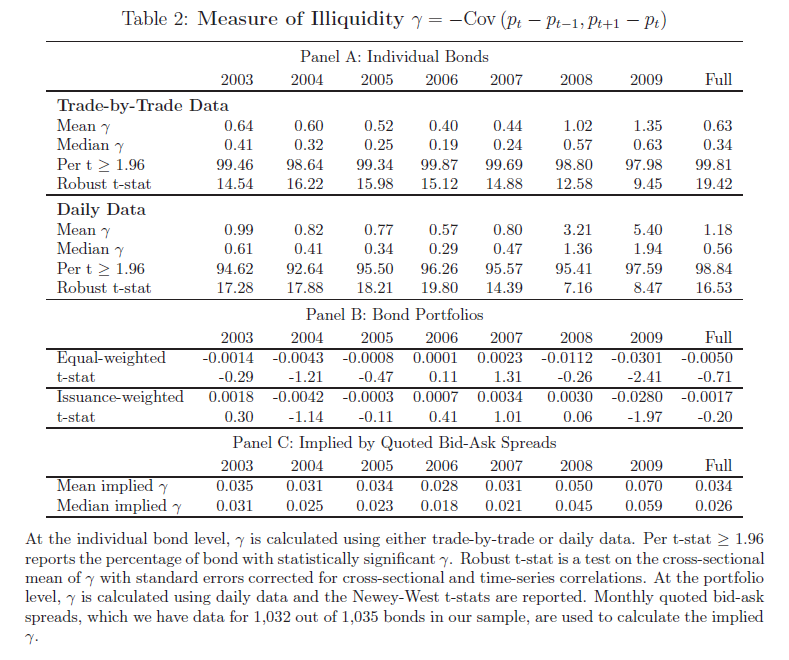

In [108]:
from IPython.display import Image
Image("../assets/table2_screenshot.jpg")

In [109]:
import config

OUTPUT_DIR = config.OUTPUT_DIR
DATA_DIR = config.DATA_DIR

In [110]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tools.tools import add_constant
import config

import warnings
warnings.filterwarnings('ignore')

In [111]:
import misc_tools
import load_wrds_bondret
import load_opensource
import data_processing as data
import table2_calc_illiquidity as calc_illiquidity

In [112]:
# Define time frames used in the paper and the updated time stamp
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2003-04-14'
end_date = '2009-06-30' 

# Step 1: Clean Merged Data for Daily Illiquidity Calculation

Before calculating illiquidity measures, it's essential to ensure that our corporate bond data is accurate and relevant. The `clean_merged_data` function takes care of preparing the pre-cleaned merged monthly and daily data by performing several critical cleaning steps:

- Loads and merges the relevant datasets within the specified date range.
- Removes any records with missing crucial price information and sorts the data chronologically.
- Adjusts for trade execution dates by incorporating a time lag to identify consecutive trades for the same bond, and filters out those that do not fall within a one-week window, accounting for holidays.
- Consolidates the cleaned data, readying it for the subsequent illiquidity analysis.

This step is crucial to ensure that the subsequent calculations are based on a dataset that reflects true trading activity without distortions from missing data or trades too far apart in time.


In [113]:
def clean_merged_data(start_date, end_date):
    """Load merged, pre-cleaned daily and monthly corporate bond data for a given time interval."""

    # load and merge pre-cleaned daily and monthly data
    df_daily = load_opensource.load_daily_bond(data_dir=DATA_DIR)
    df_bondret = load_wrds_bondret.load_bondret(data_dir=DATA_DIR)
    merged_df = data.all_trace_data_merge(df_daily, df_bondret,
                                          start_date = start_date, end_date = end_date)
    merged_df = data.sample_selection(merged_df, start_date = start_date,
                                      end_date = end_date)

    # Clean data
    merged_df = merged_df.dropna(subset=['prclean'])
    merged_df = merged_df.sort_values(by='trd_exctn_dt')
    merged_df['month_year'] = pd.to_datetime(merged_df['trd_exctn_dt']).dt.to_period('M') 

    # Lags days for day_counts
    merged_df['trd_exctn_dt_lag'] = merged_df.groupby('cusip')['trd_exctn_dt'].shift(1)
    dfDC = merged_df.dropna(subset=['trd_exctn_dt_lag'])

    # Generate a list of U.S. holidays over this period
    # Only include "daily" return if the gap between trades is less than 1-Week 
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start_date, end_date)  # 01JUL2002  # 31DEC2022
    holiday_date_list = holidays.date.tolist()

    dfDC['n']  = np.busday_count(dfDC['trd_exctn_dt_lag'].values.astype('M8[D]') , 
                                        dfDC['trd_exctn_dt'].values.astype('M8[D]'),
                                        holidays = holiday_date_list)

    df = merged_df.merge(dfDC[['cusip', 'trd_exctn_dt', 'n']],
                         left_on = ['cusip','trd_exctn_dt'], 
                         right_on = ['cusip','trd_exctn_dt'], how = "left")
    del(dfDC)
    df = df[df.n <= 7]

    return df

In [114]:
cleaned_df_paper = calc_illiquidity.clean_merged_data(start_date, end_date)
cleaned_df_paper.head()

,cusip,trd_exctn_dt,prclean,prfull,acclast,accpmt,accall,ytm,ytmt,qvolume,...,first_interest_date,last_interest_date,ncoups,amount_outstanding,n_mr,tmt,year,month_year,trd_exctn_dt_lag,n
602,36962GUR3,2003-04-15,105.974001,109.256640,3.282639,18.185417,21.468056,0.014644,0.014644,2500000.0,...,2000-11-03,2003-11-03,2.0,700000.0,1.0,1.025000,2003,2003-04,2003-04-14,1.0
603,370442AR6,2003-04-15,95.332902,96.237346,0.904444,55.335556,56.240000,0.078446,0.078446,889000.0,...,1996-03-01,2025-03-01,2.0,500000.0,7.0,22.666667,2003,2003-04,2003-04-14,1.0
604,92344SAE0,2003-04-15,106.907199,108.713796,1.806597,2.672569,4.479167,0.033530,0.033530,9000000.0,...,2002-12-15,2006-06-15,2.0,2446000.0,7.0,3.680556,2003,2003-04,2003-04-14,1.0
605,949746CC3,2003-04-15,111.335999,112.403360,1.067361,18.125000,19.192361,0.022727,0.022727,50000000.0,...,2001-02-24,2005-02-24,2.0,1000000.0,3.0,2.352778,2003,2003-04,2003-04-14,1.0
606,46625HAV2,2003-04-15,101.786597,102.608819,0.822222,0.033333,0.855556,0.035897,0.035897,22750000.0,...,2003-08-01,2007-08-01,2.0,1000000.0,5.0,4.827778,2003,2003-04,2003-04-14,1.0


# Step 2: Calculate Price Changes and Perform Additional Cleaning

In this part of the analysis pipeline, we use the `calc_deltaprc` function to compute daily price changes for corporate bonds, designed to operate on cleaned and merged daily corporate bond trade data.

This calculation is based on the Measure of Illiquidity on page 10 and 11 of the peper: $ \gamma = -\text{Cov}(p_t - p_{t-1}, p_{t+1} - p_t) $. The process involves several steps:
- Calculation of Log Prices: Transform cleaned prices to log prices for more stable numerical properties.
- Lagged and Lead Price Changes: Determine the price changes by computing lagged and lead log prices.
- Restricting Returns: Ensure that calculated price changes (returns) are within the range of -100% to 100%.
- Conversion to Percentage: Change the representation of price changes from decimal to percentage for clarity.
- Cleaning Data: Remove entries with incomplete information to maintain the quality of the dataset.
- Filtering by Trade Count: Exclude bonds with fewer than 10 trade observations to focus on more reliable data.

This function is essential for preparing the bond price data for accurate calculation of financial metrics such as illiquidity.


In [115]:
def calc_deltaprc(df):
    """Calculate delta price and delta price_lag for each daily trades with additional cleaning.
    """

    # Calculate lagged and lead log prices, and corresponding delta p (percentage returns)
    df['logprc']     = np.log(df['prclean'])
    df['logprc_lag'] = df.groupby( 'cusip' )['logprc'].shift(1)
    df['deltap']     = df ['logprc'] - df ['logprc_lag']

    # Restrict log returns to be in the interval [1,1]
    df['deltap'] = np.where(df['deltap'] > 1, 1, df['deltap'])
    df['deltap'] = np.where(df['deltap'] <-1, -1, df['deltap'])

    # Convert deltap to % i.e. returns in % as opposed to decimals
    df['deltap'] = df['deltap'] * 100
    
    # Repeat similar process for deltap_lag
    df['logprc_lead'] = df.groupby( 'cusip' )['logprc'].shift(-1)
    df['deltap_lag'] = df ['logprc_lead'] - df ['logprc']
    df['deltap_lag'] = np.where(df['deltap_lag'] > 1, 1, df['deltap_lag'])
    df['deltap_lag'] = np.where(df['deltap_lag'] <-1, -1, df['deltap_lag'])
    df['deltap_lag'] = df['deltap_lag'] * 100

    # Drop NAs in deltap, deltap_lag and bonds < 10 observations of the paired price changes
    df_final = df.dropna(subset=['deltap', 'deltap_lag', 'prclean'])

    return df_final

In [116]:
df_paper = calc_illiquidity.calc_deltaprc(cleaned_df_paper)
df_paper.head()

,cusip,trd_exctn_dt,prclean,prfull,acclast,accpmt,accall,ytm,ytmt,qvolume,...,tmt,year,month_year,trd_exctn_dt_lag,n,logprc,logprc_lag,deltap,logprc_lead,deltap_lag
1225,345397SQ7,2003-04-16,103.468001,104.176334,0.708333,22.520833,23.229167,0.055476,0.055476,10334000.0,...,1.902778,2003,2003-04,2003-04-15,1.0,4.639262,4.633919,0.534345,4.639275,0.001255
1226,370425RJ1,2003-04-16,104.210101,106.569545,2.359444,23.975000,26.334444,0.031076,0.031076,1003000.0,...,1.150000,2003,2003-04,2003-04-15,1.0,4.646409,4.646475,-0.006620,4.647230,0.082107
1227,260543BU6,2003-04-16,103.132500,105.201945,2.069444,0.000000,2.069444,0.042376,0.042376,1035000.0,...,4.611111,2003,2003-04,2003-04-15,1.0,4.636015,4.627253,0.876200,4.629933,-0.608155
1228,191219BF0,2003-04-16,111.127899,113.843177,2.715278,22.984028,25.699306,0.035189,0.035189,1130000.0,...,5.588889,2003,2003-04,2003-04-15,1.0,4.710682,4.692768,1.791380,4.695206,-1.547620
1229,37042GD52,2003-04-16,96.987273,97.108107,0.120833,4.450694,4.571528,0.075946,0.074771,25000.0,...,NaN,2003,2003-04,2003-04-15,1.0,4.574580,4.585009,-1.042888,4.574582,0.000207


# Step 3: Panel A Individual Bond: Illiquidity Metrics Calculation Using Daily Bond Data

This step involves using the `calc_annual_illiquidity_table_daily` function to calculate and summarize annual illiquidity metrics for corporate bonds. The function takes daily bond data as input and computes several statistics that capture the illiquidity of bonds on an annual basis. `create_annual_illiquidity_table` function is used as the last step in `calc_annual_illiquidity_table_daily` to generate illiquidity table with significance percentage, robust t-stat, mean and median. 

- Computes the illiquidity for each bond by month by taking the negative of the covariance between daily price changes (`deltap`) and their lagged values (`deltap_lag`).

- Aggregated the monthly illiquidity measures to obtain annual statistics, including mean and median illiquidity.

- Calculates t-statistics for the mean illiquidity of each bond and year and determines the percentage of these t-stats that are significant (>= 1.96).

- Calculates robust t-stats are calculated using OLS with HAC (heteroskedasticity and autocorrelation consistent) standard errors.

- Calculate overall statistics across the full sample period.

- Compiles all these metrics into a table that presents the mean and median illiquidity, the percentage of significant t-statistics, and robust t-statistics for each year, as well as for the full sample period.

This comprehensive illiquidity metric calculation allows us to understand the annual and overall liquidity characteristics of the corporate bond market.

In [117]:
def create_annual_illiquidity_table(Illiq_month):
    """Create Panel A illquidity table with cleaned monthly illiquidity data."""

    overall_illiq_mean = np.mean(Illiq_month['illiq'])
    overall_illiq_median = Illiq_month['illiq'].median()

    # Calculate t-statistics for each cusip in each year
    Illiq_month['t stat'] = Illiq_month.groupby(['cusip', 'year'])['illiq'].transform(
        lambda x: (x.mean() / x.sem()) if x.sem() > 0 else np.nan)

    # Identify the entries with t-stat >= 1.96 and calculate the percentage of significant t-stats for each year
    Illiq_month['significant'] = Illiq_month['t stat'] >= 1.96
    percent_significant = Illiq_month.groupby('year')['significant'].mean() * 100
    Illiq_month = Illiq_month.dropna(subset=['illiq', 't stat'])
    overall_percent_significant = Illiq_month['significant'].mean() * 100
    
    # Calculate robust t-stat for each year
    def get_robust_t_stat(group):
        """Run OLS on a constant term only (mean of illiq) to get the intercept's t-stat."""
        X = add_constant(group['illiq'])
        ols_result = OLS(group['illiq'], X).fit(cov_type='HAC', cov_kwds={'maxlags':1})

        return abs(ols_result.tvalues[0])


    robust_t_stats = Illiq_month.groupby('year').apply(get_robust_t_stat)
    
    
    def calculate_overall_robust_t_stat(series):
        X = add_constant(series)
        ols_result = OLS(series, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
        return abs(ols_result.tvalues[0])

    # Call the function and assign the result to overall_robust_t_stat
    overall_robust_t_stat = calculate_overall_robust_t_stat(Illiq_month['illiq'].dropna())

    # Combine the results
    table2_daily = pd.DataFrame({
        'Year': robust_t_stats.index,
        'Mean illiq': Illiq_month.groupby('year')['illiq'].mean(),
        'Median illiq': Illiq_month.groupby('year')['illiq'].median(),
        'Per t greater 1.96': percent_significant,
        'Robust t stat': robust_t_stats.values
    }).reset_index(drop=True)
    
    overall_data = pd.DataFrame({
        'Year': ['Full'],
        'Mean illiq': [overall_illiq_mean],
        'Median illiq': [overall_illiq_median],
        'Per t greater 1.96': [overall_percent_significant],
        'Robust t stat': [overall_robust_t_stat]
    })

    table2_daily = pd.concat([table2_daily, overall_data], ignore_index=True)

    return Illiq_month, table2_daily

In [118]:
def calc_annual_illiquidity_table_daily(df):
    """Calculate illiquidity = -cov(deltap, deltap_lag) using daily data, by month."""

    tqdm.pandas()
    
    Illiq_month = df.groupby(['cusip','month_year'] )[['deltap','deltap_lag']]\
        .progress_apply(lambda x: x.cov().iloc[0,1]) * -1
    Illiq_month = Illiq_month.reset_index()
    Illiq_month.columns = ['cusip','month_year','illiq']
    Illiq_month['year'] = Illiq_month['month_year'].dt.year
    Illiq_month = Illiq_month.dropna(subset=['illiq'])
    # Illiq_month = Illiq_month[Illiq_month['illiq'] < 2000]  # for outliers
    Illiq_month, table2_daily = create_annual_illiquidity_table(Illiq_month)
    
    return Illiq_month, table2_daily

In [119]:
illiq_daily_paper, table2_daily_paper = calc_illiquidity.calc_annual_illiquidity_table_daily(df_paper)
table2_daily_paper

  0%|          | 0/47630 [00:00<?, ?it/s]

100%|██████████| 47630/47630 [00:26<00:00, 1771.21it/s]


,Year,Mean illiq,Median illiq,Per t greater 1.96,Robust t stat
0,2003,1.012431,0.118649,77.283913,2.541571
1,2004,1.054907,0.061028,77.377015,10.183842
2,2005,0.851126,0.040949,80.297199,4.067339
3,2006,0.409025,0.036393,87.914056,6.715445
4,2007,1.116023,0.064962,87.326335,1.815385
5,2008,13.271568,0.232770,67.408497,20.787846
6,2009,17.980450,0.334487,69.007369,1.186281
7,Full,3.119932,0.072591,79.679268,17.057181


# Step 4: Summary Statistics Compilation Using Daily Illiquidity Data

This step entails utilizing the `create_summary_stats` function to compile key summary statistics that characterize daily illiquidity data for corporate bonds over different years--min, mean, median, max, 25%, 75% std monthly illiquidity per cusip and mean t-stat. This aids in understanding the distribution and central tendencies of bond illiquidity and t-statistics on an annual basis.

In [120]:
def create_summary_stats(illiq_daily):
    """Calculate relevant summary statistics of the illiquidity daily data."""
    
    summary_stats = illiq_daily.groupby('year').agg({
    'illiq': ['min', 'mean', lambda x: x.quantile(0.25), 'median',
              lambda x: x.quantile(0.75), 'max', 'std'],
    't stat': 'mean'
    })
    summary_stats.columns = ['min illiq', 'mean illiq', 'q1 0.25', 'median',
                             'q3 0.75', 'max illiq', 'std illiq', 'mean t stat']
    summary_stats.reset_index(inplace=True)

    return summary_stats

In [121]:
illiq_daily_summary_paper = create_summary_stats(illiq_daily_paper)
illiq_daily_summary_paper

,year,min illiq,mean illiq,q1 0.25,median,q3 0.75,max illiq,std illiq,mean t stat
0,2003,-129.009527,1.012431,0.030657,0.118649,0.416826,1127.480854,15.926022,2.925198
1,2004,-6.984261,1.054907,0.014045,0.061028,0.242994,718.689577,17.546287,3.040041
2,2005,-12.645612,0.851126,0.009378,0.040949,0.171790,2116.809197,29.728685,3.109209
3,2006,-20.151911,0.409025,0.007929,0.036393,0.161738,787.236482,9.327834,3.437520
4,2007,-9.345427,1.116023,0.015308,0.064962,0.240230,1764.116960,26.605177,3.248946
5,2008,-830.664798,13.271568,0.059508,0.232770,1.132950,5836.747235,190.986134,2.517271
6,2009,-202.045271,17.980450,0.070607,0.334487,2.013726,8571.428571,233.059386,2.654317


In [122]:
illiq_daily_paper[illiq_daily_paper['illiq'] > 2000]

,cusip,month_year,illiq,year,t stat,significant
15350,247126AE5,2009-04,2780.997196,2009,1.176218,False
15370,247361YE2,2005-10,2116.809197,2005,1.020795,False
17130,26632QAH6,2008-01,2001.066833,2008,3.287915,True
17132,26632QAH6,2008-03,5434.541339,2008,3.287915,True
17133,26632QAH6,2008-04,5836.747235,2008,3.287915,True
17134,26632QAH6,2008-05,5758.264060,2008,3.287915,True
17138,26632QAH6,2008-09,3333.333371,2008,3.287915,True
17140,26632QAH6,2008-12,5714.285714,2008,3.287915,True
17160,26632QAK9,2008-06,2037.730503,2008,0.797720,False
27609,432848AS8,2008-12,3560.187974,2008,1.172602,False


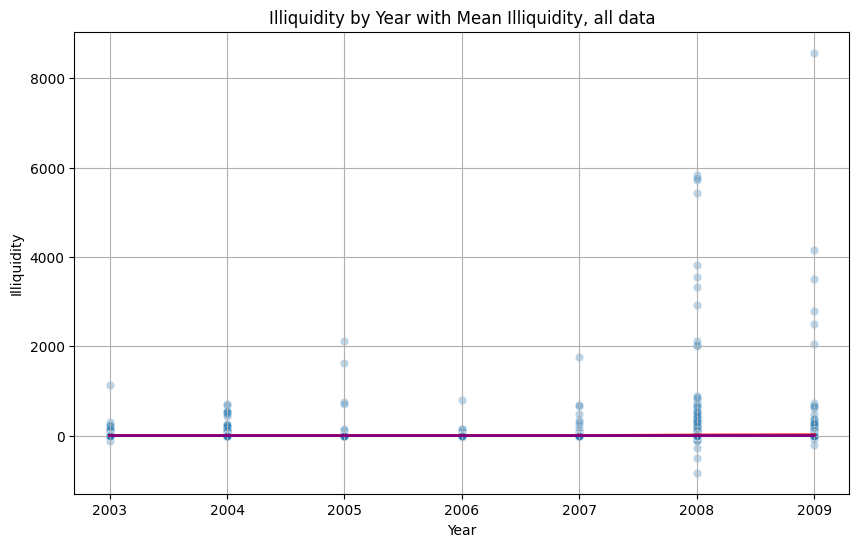

In [123]:
# Scatter plot of illiquidity by year, all data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=illiq_daily_paper, x='year', y='illiq', alpha=0.3)

# Line plot for the mean illiquidity by year
sns.lineplot(data=illiq_daily_summary_paper, x='year', y='mean illiq', color='red', lw=2)
sns.lineplot(data=illiq_daily_summary_paper, x='year', y='median', color='purple', lw=2)
plt.title('Illiquidity by Year with Mean Illiquidity, all data')
plt.xlabel('Year')
plt.ylabel('Illiquidity')
plt.grid(True)
plt.show()


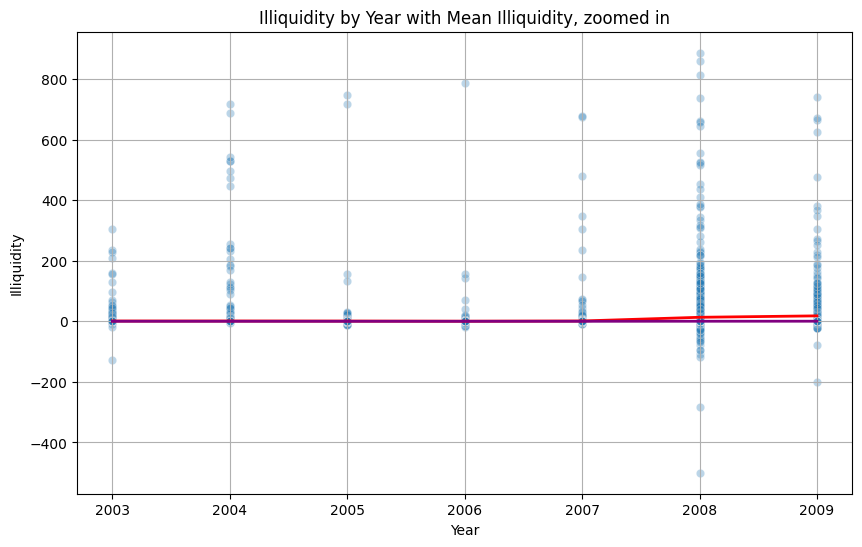

In [124]:
# Scatter plot of illiquidity by year
plt.figure(figsize=(10, 6))
sns.scatterplot(data=illiq_daily_paper[(illiq_daily_paper['illiq'] <= 1000) & (illiq_daily_paper['illiq'] >= -500)], x='year', y='illiq', alpha=0.3)

# Line plot for the mean illiquidity by year
sns.lineplot(data=illiq_daily_summary_paper, x='year', y='mean illiq', color='red', lw=2)
sns.lineplot(data=illiq_daily_summary_paper, x='year', y='median', color='purple', lw=2)
plt.title('Illiquidity by Year with Mean Illiquidity, zoomed in')
plt.xlabel('Year')
plt.ylabel('Illiquidity')
plt.grid(True)
plt.show()


# Step 5: Panel A Using MMN Corrected Daily Bond Data

Now, we apply similar calculation in Step 3 and 4 using MMN corrected daily bond data. Since the MMN corrected daily bond data contains illiquidty directly, `calc_illiq_w_mmn_corrected` performs cleaning on MMN corrected data and apply `create_annual_illiquidity_table` to generate the similar Panel A (daily data) illiquidity final table, ready for comparison. We then use the in Step 4 to produce summary stats using cleaned MMN corrected daily bond data.

In [125]:
def calc_illiq_w_mmn_corrected(start_date, end_date, cleaned_df):
    """Use clean merged cusips to filter out mmn corrected monthly data to generate illiquidity table."""

    mmn  = load_opensource.load_mmn_corrected_bond(data_dir=DATA_DIR)
    
    # Filter out corrected data using cleaned cusips and dates
    mmn = mmn[(mmn['date'] >= start_date) & (mmn['date'] <= end_date)]
    unique_cusip = np.unique(cleaned_df['cusip'])
    mmn = mmn[mmn['cusip'].isin(unique_cusip)]
    
    # Clean data
    mmn['year'] = pd.to_datetime(mmn['date']).dt.to_period('Y') 
    mmn = mmn.dropna(subset=['ILLIQ'])
    mmn['illiq'] = mmn['ILLIQ']
    
    mmn, table2_daily = create_annual_illiquidity_table(mmn)
    
    return mmn, table2_daily

In [126]:
mmn_paper, table2_daily_mmn_paper = calc_illiquidity.calc_illiq_w_mmn_corrected(
    start_date, end_date, cleaned_df_paper)
table2_daily_mmn_paper

,Year,Mean illiq,Median illiq,Per t greater 1.96,Robust t stat
0,2003,1.126366,0.107766,71.480204,2.304529
1,2004,1.351033,0.061672,71.377686,10.106060
2,2005,0.433418,0.045342,79.905201,5.575357
3,2006,0.329079,0.045745,83.898432,0.497943
4,2007,0.403477,0.080262,88.265670,0.774973
5,2008,4.387134,0.269606,61.268378,10.143215
6,2009,8.436064,0.424655,63.152455,0.823691
7,Full,1.507753,0.078402,75.995184,7.206051


In [128]:
illiq_daily_summary_mmn_paper = calc_illiquidity.create_summary_stats(mmn_paper)
illiq_daily_summary_mmn_paper

,year,min illiq,mean illiq,q1 0.25,median,q3 0.75,max illiq,std illiq,mean t stat
0,2003,-9.143287,1.126366,0.025527,0.107766,0.345540,751.217416,16.797166,2.733560
1,2004,-20.038684,1.351033,0.013673,0.061672,0.247137,778.589263,21.198697,2.832352
2,2005,-18.137484,0.433418,0.010328,0.045342,0.178552,926.156664,12.341459,2.995291
3,2006,-40.331088,0.329079,0.010483,0.045745,0.167151,550.736267,7.142692,3.299684
4,2007,-4.427193,0.403477,0.022036,0.080262,0.272474,500.221470,6.729276,3.223165
5,2008,-249.784908,4.387134,0.065605,0.269606,1.129595,1084.715175,34.324809,2.246503
6,2009,-73.678064,8.436064,0.086623,0.424655,2.289379,925.409177,46.130775,2.377221


In [140]:
mmn_paper['year'] = mmn_paper['year'].astype('int64')
illiq_daily_summary_mmn_paper['year'] = illiq_daily_summary_mmn_paper['year'].astype('int64')
mmn_paper.dropna(subset=['illiq'], inplace=True)

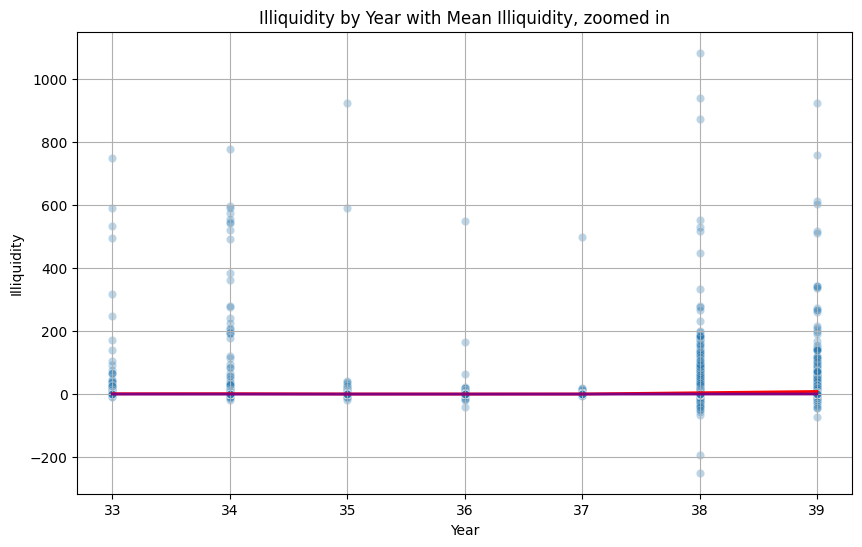

In [141]:
# Scatter plot of illiquidity by year
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mmn_paper, x='year', y='illiq', alpha=0.3)

# Line plot for the mean illiquidity by year
sns.lineplot(data=illiq_daily_summary_mmn_paper, x='year', y='mean illiq', color='red', lw=2)
sns.lineplot(data=illiq_daily_summary_mmn_paper, x='year', y='median', color='purple', lw=2)
plt.title('Illiquidity by Year with Mean Illiquidity, zoomed in')
plt.xlabel('Year')
plt.ylabel('Illiquidity')
plt.grid(True)
plt.show()

# Step 6: Panel B Bond Portfolios: Portfolio-Based Annual Illiquidity Metrics Calculation

The `calc_annual_illiquidity_table_portfolio` function computes the illiquidity metrics for corporate bonds by constructing equal-weighted and issuance-weighted portfolio returns on a daily basis and then calculate portfolio illiquidity on an annual basis. The function systematically processes transaction-level bond data to assess market liquidity through portfolio aggregation, offering a more holistic view of the market dynamics. 

- Equal-Weighted Portfolio Calculation: Creat an equal-weighted portfolio for each trading day by averaging the daily price changes (deltap) and their lagged values (deltap_lag). It then groups these daily averages by year to calculate the negative covariance between the deltap and deltap_lag to derive the illiquidity measure for each year. Additionally, a t-statistic for the mean illiquidity of the equal-weighted portfolio is computed.

- Issuance-Weighted Portfolio Calculation: Each bond is calculated with its $ \text{issuance} = \text{offering amount} \times \text{principal amount} \times \text{offering price} / 100 / 1,000,000 $ , and all bonds deltap and deltap_lag are aggregated on a daily basis weighted by issurance. The following steps are similar to Equal-Weighted Portfolio Calculation.

- Calculate overall statistics across the full sample period.

- Compiles all these metrics into a table that presents the mean equal_weighted portfolio and t-stat, mean issuance-weighted portfolio illiquidity and t-stat for each year, as well as for the full sample period.

In [ ]:
def calc_annual_illiquidity_table_portfolio(df):
    """Calculate illiquidity by using equal weighted and issurance weighted portfolios for each year.
    """
    # Equal weighted
    df_ew = df.groupby('trd_exctn_dt')[['deltap', 'deltap_lag']].mean().reset_index()
    df_ew['year'] = df_ew['trd_exctn_dt'].dt.year

    tqdm.pandas()
    
    Illiq_port_ew = df_ew.groupby(['year'] )[['deltap','deltap_lag']]\
        .progress_apply(lambda x: x.cov().iloc[0,1]) * -1
    Illiq_port_ew = Illiq_port_ew.reset_index()
    Illiq_port_ew.columns = ['year','Equal-weighted']
    Illiq_port_ew = Illiq_port_ew.dropna(subset=['Equal-weighted'])
    
    # for full equal weighted porfolio illiquidity
    df_ew['full'] = 1 
    Illiq_port_ew_full = df_ew.groupby(['full'] )[['deltap','deltap_lag']]\
        .progress_apply(lambda x: x.cov().iloc[0,1]) * -1
    
    # Calculate t-stat for equal-weighted illiquidity
    Illiq_port_ew['EW t-stat'] = Illiq_port_ew.apply(
        lambda row: row['Equal-weighted'] / (df_ew[df_ew['year'] == row['year']]['deltap'].std() / 
                                             (len(df_ew[df_ew['year'] == row['year']]) ** 0.5)), axis=1)
    
    # Calculate t-stat for full sample
    ew_full_mean = Illiq_port_ew_full[1]
    ew_full_std = df_ew['deltap'].std()
    ew_full_size = len(df_ew)
    ew_full_t_stat = ew_full_mean / (ew_full_std / (ew_full_size ** 0.5))
    
    # Issurance weighted
    df['issurance'] = df['offering_amt'] * df['principal_amt'] * df['offering_price'] / 100 / 1000000
    df['value_weighted_deltap'] = df['deltap'] * df['issurance']
    df['value_weighted_deltap_lag'] = df['deltap_lag'] * df['issurance']

    # Group by day and calculate the sum of the value-weighted columns and issurance
    df_vw = df.groupby('trd_exctn_dt').agg(
        total_value_weighted_deltap=pd.NamedAgg(column='value_weighted_deltap', aggfunc='sum'),
        total_value_weighted_deltap_lag=pd.NamedAgg(column='value_weighted_deltap_lag', aggfunc='sum'),
        total_issurance=pd.NamedAgg(column='issurance', aggfunc='sum')
    )

    # Calculate the average value-weighted deltap and deltap_lag
    df_vw['deltap_vw'] = df_vw['total_value_weighted_deltap'] / df_vw['total_issurance']
    df_vw['deltap_lag_vw'] = df_vw['total_value_weighted_deltap_lag'] / df_vw['total_issurance']
    df_vw['year'] = df_vw.index.year
    
    tqdm.pandas()
    Illiq_port_vw = df_vw.groupby(['year'])[['deltap_vw','deltap_lag_vw']]\
        .progress_apply(lambda x: x.cov().iloc[0,1]) * -1
    Illiq_port_vw = Illiq_port_vw.reset_index()
    Illiq_port_vw.columns = ['year','Issuance-weighted']
    Illiq_port_vw = Illiq_port_vw.dropna(subset=['Issuance-weighted'])

    # for full equal weighted porfolio illiquidity
    df_vw['full'] = 1
    Illiq_port_vw_full = df_vw.groupby(['full'] )[['deltap_vw','deltap_lag_vw']]\
        .progress_apply(lambda x: x.cov().iloc[0,1]) * -1
        
    # Calculate t-stat for issuance-weighted illiquidity
    Illiq_port_vw['IW t-stat'] = Illiq_port_vw.apply(
        lambda row: row['Issuance-weighted'] / (df_vw[df_vw['year'] == row['year']]['deltap_vw'].std() / 
                                                 (len(df_vw[df_vw['year'] == row['year']]) ** 0.5)), axis=1)

    # Calculate t-stat for full sample
    iw_full_mean = Illiq_port_vw_full[1]
    iw_full_std = df_vw['deltap_vw'].std()
    iw_full_size = len(df_vw)
    iw_full_t_stat = iw_full_mean / (iw_full_std / (iw_full_size ** 0.5))

    table2_port = pd.DataFrame({
        'Year': Illiq_port_vw['year'],
        'Equal weighted': Illiq_port_ew['Equal-weighted'],
        'EW t stat': Illiq_port_ew['EW t-stat'],
        'Issuance weighted': Illiq_port_vw['Issuance-weighted'],
        'IW t stat': Illiq_port_vw['IW t-stat']
    }).reset_index(drop=True)
    
    overall_data = pd.DataFrame({
        'Year': ['Full'],
        'Equal weighted': Illiq_port_ew_full,
        'EW t stat': ew_full_t_stat,
        'Issuance weighted': Illiq_port_vw_full,
        'IW t stat': iw_full_t_stat
    })

    table2_port = pd.concat([table2_port, overall_data], ignore_index=True)
    
    return table2_port

In [ ]:
table2_port_paper = calc_illiquidity.calc_annual_illiquidity_table_portfolio(df_paper)
table2_port_paper

100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


,Year,Equal weighted,EW t stat,Issuance weighted,IW t stat
0,2003,-0.006087,-0.294912,-0.009461,-0.432602
1,2004,-0.004753,-0.331050,-0.005822,-0.388742
2,2005,-0.003060,-0.249180,-0.003177,-0.322195
3,2006,-0.001192,-0.146704,-0.000798,-0.091350
4,2007,0.003547,0.361148,0.000779,0.084557
5,2008,-0.069819,-1.338890,-0.061089,-1.608162
6,2009,-0.089945,-1.818492,-0.050784,-1.657787
7,Full,-0.021060,-2.047658,-0.016470,-2.087139


# Step 7: Panel C Implied by Quoted Bid-Ask Spreads: Annual Implied Illiquidity Using Monthly Quoted Bid-Ask Spread

In this section, we focus on analyzing the illiquidity implied by quoted bid-ask spreads of corporate bonds on an annual basis using `calc_annual_illiquidity_table_spd`. 


- For each year, calculates the mean and median of the monthly `t_spread`, which represent the implied gamma. 

- Calculate overall statistics across the full sample period.

- Compiles all these metrics into a table that presents the mean and median implied illiquidity for each year, as well as for the full sample period.

By computing these statistics, the function provides insights into the liquidity of the corporate bond market as implied by the bid-ask spreads over time. As shown in the paper, not only does the quoted bid-ask spread fail to capture the overall level of illiquidity, but it also fails to explain the cross-sectional variation in bond illiquidity and its asset pricing implications.

In [ ]:
def calc_annual_illiquidity_table_spd(df):
    """Calculate mean and median gamma implied by quoted bid-ask spreads by year.
    """
    df_unique = df.groupby(['cusip', 'month_year'])['t_spread'].first().reset_index()
    df_unique['year'] = df_unique['month_year'].dt.year  
    df_unique = df_unique.sort_values(by='month_year')

    Illiq_mean_table = df_unique.groupby('year')['t_spread'].mean()
    overall_illiq_mean = df_unique['t_spread'].mean()
    overall_illiq_median = df_unique['t_spread'].median()
    
    table2_spd = pd.DataFrame({
        'Year': Illiq_mean_table.index,
        'Mean implied gamma': df_unique.groupby('year')['t_spread'].mean(),
        'Median implied gamma': df_unique.groupby('year')['t_spread'].median(),
    }).reset_index(drop=True)
    
    overall_data = pd.DataFrame({
        'Year': ['Full'],
        'Mean implied gamma': [overall_illiq_mean], 
        'Median implied gamma': [overall_illiq_median]
    })
    
    table2_spd = pd.concat([table2_spd, overall_data], ignore_index=True)
    
    return table2_spd

In [ ]:
table2_spd_paper = calc_illiquidity.calc_annual_illiquidity_table_spd(df_paper) 
table2_spd_paper

,Year,Mean implied gamma,Median implied gamma
0,2003,0.006595,0.004536
1,2004,0.005371,0.003603
2,2005,0.004684,0.003305
3,2006,0.004274,0.003142
4,2007,0.005705,0.004373
5,2008,0.012404,0.008957
6,2009,0.015906,0.012258
7,Full,0.006560,0.004239
